In [1]:
import numpy as np
from copy import copy
import cvxpy as cvx
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import imageio
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [32]:
m = []

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 5808900
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 0, rho_x = 1.00e-03
Variables n = 28900, constraints m = 29001
Cones:	primal zero / dual free vars: 1
	linear vars: 29000
WARN: aa_init returned NULL, no acceleration applied.
Setup time: 8.20e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.68e+00  2.04e+02  1.00e+00 -9.20e+03  2.35e+03  1.53e-12  2.21e-01 
   100| 1.07e-02  5.59e-01  1.12e-01  1.28e+01  1.01e+01  7.69e-14  8.16e+00 
   200| 4.09e-03  1.93e-01  1.

/usr/local/lib/python3.6/dist-packages/cvxpy/problems/problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


f_value:  0.23831644120958698


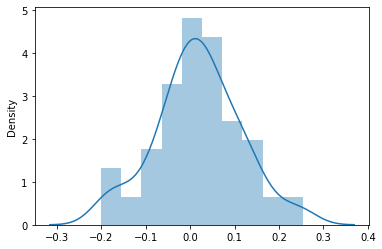

In [43]:
np.random.seed(10)
large_df = pd.DataFrame(columns=['problem_value', 'mean_r.value'])
# f-statistic
# fstat = np.random.uniform(1,100,(144,4))
# cov = np.random.uniform(1,100,(10,4))
inputs_ = np.random.normal(0.01,0.099,100)
inputs = inputs_.copy()
corr, corr2 = pd.DataFrame(np.random.uniform(0.01,0.099,(288,200))), pd.DataFrame(np.random.uniform(0.01,0.099,(288,200)))
# chi-squared
# corr, corr2 = None, None
# corr, corr2 = pd.DataFrame(np.random.uniform(0.01,0.099,(288,200))), pd.DataFrame(np.random.uniform(0.01,0.099,(288,200)))
# mahalanobis
# corr, corr2 = pd.DataFrame(np.random.uniform(0.01,0.099,(288,200))), pd.DataFrame(np.random.uniform(0.01,0.099,(288,200)))
# input_index = corr2.index.astype(np.int64).values
# f-statistic
yrj = np.matmul(corr2.T.corr('spearman').replace(np.nan, 0).values,corr2.values) # 144 x 4
# chi-squared
# yrj = corr.values * corr2.values # 144 x 144
# mahalanobis
# yrj = np.sqrt(np.square(np.matmul(corr.values,np.linalg.inv(np.cov(corr2.T.values))) * corr.values)) # 144 x 144
mean_r = cvx.Variable((corr2.values.shape[0],100))
yro = corr2.values
xio = inputs
xij = np.random.normal(0.01,0.099,(200,100))
vi = cvx.Variable((inputs.shape[0],1))
objective = cvx.Minimize(cvx.sum(cvx.matmul(mean_r.T, yro)))
constraints = [mean_r >= 0,cvx.matmul(vi.T, xio)==1,
              (cvx.matmul(xij,vi).T-cvx.sum(cvx.matmul(mean_r.T, yrj),axis=0,keepdims=True)) <= 0]
problem = cvx.Problem(objective, constraints)
problem.solve(verbose=True, solver=cvx.SCS, max_iters=1000)
df = pd.DataFrame(mean_r.value, columns=np.arange(mean_r.value.shape[1]))
df['problem_value'] = [problem.value]*mean_r.value.shape[0]
# df['corr2_index'] = input_index
large_df = pd.concat([large_df,df], axis=0)
large_df = large_df.reset_index()

m[:,:,0] = mean_r.value

seaborn.distplot(inputs_)

## f statistical value

f_value = 0.0
between_group = 4 * ((yro.mean(axis=0) - yro.mean())**2).sum() * 4 / 3
within_group = xio.var(axis=0).sum() * 10/(10-1)
f_value = between_group / within_group
print("f_value: ", f_value)

In [36]:
m = np.dstack(m)
imageio.imwrite("image_full.png", m)

Lossy conversion from float64 to uint8. Range [-2.238069969168121e-05, 0.0026366089176252574]. Convert image to uint8 prior to saving to suppress this warning.


In [44]:
(m[:,:,0].mean(), m[:,:,1].mean(), m[:,:,2].mean())

(1.252780848959894e-05, 3.79600563991207e-09, 1.1228048794337704e-08)

In [45]:
(np.linalg.norm(m[:,:,0]), np.linalg.norm(m[:,:,1]), np.linalg.norm(m[:,:,2]))

(0.0272204292782118, 6.8470291779016e-07, 7.075756898412615e-05)

<AxesSubplot:>

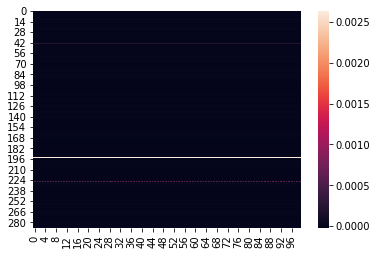

In [40]:
seaborn.heatmap(m[:,:,0])

<AxesSubplot:>

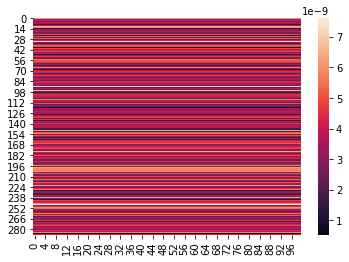

In [41]:
seaborn.heatmap(m[:,:,1])

<AxesSubplot:>

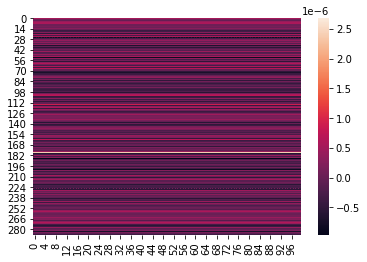

In [42]:
seaborn.heatmap(m[:,:,2])

In [ ]:
seaborn.distplot(vi.value)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'f_value: 20.674021614200157'}, ylabel='Density'>

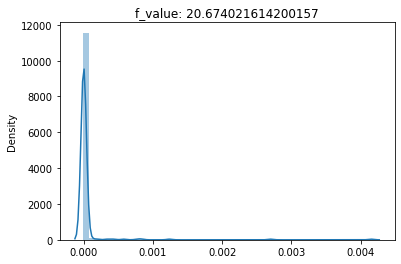

In [10]:
f_value = 0.0
between_group = 200 * ((yro.mean(axis=1) - yro.mean())**2).sum()
within_group = xio.var(axis=0).sum() * 200/(200-1)
f_value = between_group / within_group
import matplotlib.pyplot as plt
plt.title("f_value: " + str(f_value))
seaborn.distplot(mean_r.value)

KeyboardInterrupt: 

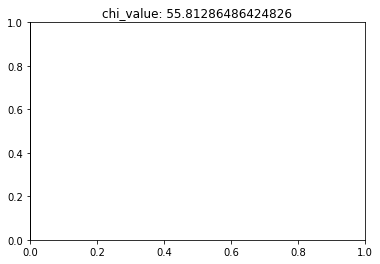

In [11]:
# alternative hypothesis saying it is dependent between input and DMU (s)
chi_value = 0.0
observed = xio.reshape(1,-1)
expected = xij
chi_value = ((observed - expected)**2 / expected).sum() * 1 / 100
import matplotlib.pyplot as plt
plt.title("chi_value: " + str(chi_value))
seaborn.histplot(mean_r.value)

In [ ]:
t_score = ((yro.mean() - xio.mean()) / (yro.std()).sum()*288*200/(288*200-1))
import matplotlib.pyplot as plt
plt.title("t_score: " + str(t_score))
seaborn.histplot(mean_r.value)

In [ ]:
f_value = 0.0
between_group = 4 * ((yro.mean(axis=0) - yro.mean())**2).sum() * 4 / 3
within_group = xio.var(axis=0).sum() * 10/(10-1)
f_value = between_group / within_group
import matplotlib.pyplot as plt
plt.title("f_value: " + str(f_value))
seaborn.distplot(large_df['mean_r.value'])

In [ ]:
# alternative hypothesis saying it is dependent between input and DMU (s)
chi_value = 0.0
observed = xio.reshape(-1,1)
expected = xij
chi_value = ((observed - expected)**2 / expected).sum() * 1 / 4
import matplotlib.pyplot as plt
plt.title("chi_value: " + str(chi_value))
seaborn.distplot(large_df['mean_r.value'])

#### F-stat example

In [ ]:
inputs_, vi.value, xij, yrj, yro

In [ ]:
from scipy.stats import chisquare
chisquare(np.random.normal(0.1,0.4,100), 
      f_exp=[np.ones(100), 
        np.ones(100)*1.01, np.ones(100)*1.02, np.ones(100)*1.03, 
        np.ones(100)*1.04, np.ones(100)*1.05, np.ones(100)*1.06, np.ones(100)*1.07], axis=1)